In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.structured import apply_cats, proc_df
from fastai.column_data import *
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import dill as pickle
from IPython.display import display

pd.options.display.max_columns = None
import numpy as np
np.set_printoptions(threshold=50, edgeitems=20)
data_path=Path('data/')
PATH = data_path
SK_ID_CURR = "SK_ID_CURR"

# TODOS:

Try to fix overfitting - by remove extra information

In [16]:
cred_card_bal = pickle.load(open('data/credit_card_balance','rb'))
pos_cash_bal = pickle.load(open('data/POS_CASH_balance','rb'))
prev = pickle.load(open('data/previous_application','rb'))
bureau_bal = pickle.load(open('data/bureau_balance','rb'))
install = pickle.load(open('data/installments_payments','rb'))
bureau = pickle.load(open('data/bureau','rb'))
application_train = pickle.load(open('data/application_train','rb'))
application_test = pickle.load(open('data/application_test','rb'))

In [17]:
merged_df = pickle.load(open('data/merged_df.pickle','rb'))

In [18]:
len(merged_df.columns)

213

In [6]:
prev.sample(10)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
1465091,2509186,194131,Consumer loans,9843.885,89955.0,80959.5,8995.5,89955.0,FRIDAY,14,Y,1,0.108909,NaN,NaN,XAP,Approved,-268,Cash through the bank,XAP,NaN,New,Mobile,POS,XNA,Country-wide,30,Connectivity,12.0,high,POS mobile with interest,365243.0,-234.0,96.0,365243.0,365243.0,0.0
1569859,1950499,436789,Consumer loans,6265.350,51129.0,56191.5,0.0,51129.0,WEDNESDAY,16,Y,1,0.000000,NaN,NaN,XAP,Approved,-1689,Cash through the bank,XAP,Unaccompanied,Refreshed,Computers,POS,XNA,Stone,134,Consumer electronics,12.0,high,POS household with interest,365243.0,-1657.0,-1327.0,-1507.0,-1503.0,0.0
837785,1719574,195058,Revolving loans,4500.000,90000.0,90000.0,NaN,90000.0,FRIDAY,12,Y,1,NaN,NaN,NaN,XAP,Approved,-280,XNA,XAP,NaN,Repeater,XNA,Cards,x-sell,Credit and cash offices,-1,XNA,0.0,XNA,Card X-Sell,-280.0,-238.0,365243.0,365243.0,365243.0,0.0
10131,1080603,259270,Consumer loans,11717.865,95625.0,105093.0,0.0,95625.0,SATURDAY,9,Y,1,0.000000,NaN,NaN,XAP,Approved,-1693,Cash through the bank,XAP,Children,New,Clothing and Accessories,POS,XNA,Regional / Local,89,Clothing,12.0,high,POS industry with interest,365243.0,-1658.0,-1328.0,-1328.0,-1321.0,0.0
789430,1653017,343390,Consumer loans,9151.920,65565.0,82080.0,0.0,65565.0,SATURDAY,14,Y,1,0.000000,NaN,NaN,XAP,Approved,-1366,Cash through the bank,XAP,Unaccompanied,New,Consumer Electronics,POS,XNA,Stone,350,Consumer electronics,12.0,high,POS household with interest,365243.0,-1335.0,-1005.0,-1155.0,-1148.0,0.0
547939,1106218,239777,Consumer loans,13609.530,80496.0,85810.5,0.0,80496.0,FRIDAY,16,Y,1,0.000000,NaN,NaN,XAP,Approved,-2579,Cash through the bank,XAP,Unaccompanied,Repeater,Consumer Electronics,POS,XNA,Country-wide,-1,Consumer electronics,8.0,high,POS household with interest,365243.0,-2548.0,-2338.0,-2338.0,-2325.0,1.0
1527782,1889783,188976,Consumer loans,18160.740,137070.0,122130.0,22500.0,137070.0,THURSDAY,9,Y,1,0.169429,NaN,NaN,XAP,Approved,-1398,XNA,XAP,"Spouse, partner",New,Computers,POS,XNA,Regional / Local,1,Consumer electronics,8.0,middle,POS household with interest,365243.0,-1367.0,-1157.0,-1157.0,-1149.0,0.0
1288295,2643797,250697,Consumer loans,4669.785,18360.0,21834.0,0.0,18360.0,SUNDAY,16,Y,1,0.000000,NaN,NaN,XAP,Approved,-919,Cash through the bank,XAP,Family,Repeater,Mobile,POS,XNA,Country-wide,24,Connectivity,6.0,high,POS mobile with interest,365243.0,-888.0,-738.0,-798.0,-792.0,0.0
779122,2704204,372461,Cash loans,39562.605,454500.0,546529.5,NaN,454500.0,WEDNESDAY,17,Y,1,NaN,NaN,NaN,XNA,Approved,-436,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,18.0,middle,Cash X-Sell: middle,365243.0,-406.0,104.0,-226.0,-222.0,1.0
900724,1980889,157870,Consumer loans,11844.315,118458.0,106609.5,11848.5,118458.0,SATURDAY,16,Y,1,0.108934,NaN,NaN,XAP,Approved,-2140,Cash through the bank,XAP,Family,New,Consumer Electronics,POS,XNA,Country-wide,500,Consumer electronics,10.0,low_normal,POS household with interest,365243.0,-2108.0,-1838.0,-1838.0,-1831.0,0.0


In [7]:
list(merged_df.columns)

['AMT_ANNUITY',
 'AMT_CREDIT',
 'AMT_GOODS_PRICE',
 'AMT_INCOME_TOTAL',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'APARTMENTS_AVG',
 'APARTMENTS_MEDI',
 'APARTMENTS_MODE',
 'BASEMENTAREA_AVG',
 'BASEMENTAREA_MEDI',
 'BASEMENTAREA_MODE',
 'CNT_CHILDREN',
 'CNT_FAM_MEMBERS',
 'CODE_GENDER',
 'COMMONAREA_AVG',
 'COMMONAREA_MEDI',
 'COMMONAREA_MODE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_REGISTRATION',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'ELEVATORS_AVG',
 'ELEVATORS_MEDI',
 'ELEVATORS_MODE',
 'EMERGENCYSTATE_MODE',
 'ENTRANCES_AVG',
 'ENTRANCES_MEDI',
 'ENTRANCES_MODE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'FLAG_CONT_MOBILE',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT

In [8]:
def most_recent_sk_id(curr_sk_id):
    columns = prev[prev["SK_ID_CURR"] == curr_sk_id]
    most_recent_loan = columns[columns["DAYS_DECISION"] == max(columns["DAYS_DECISION"])]
    recent_prev_sk_id = list(most_recent_loan["SK_ID_PREV"])[0]
    return recent_prev_sk_id

In [9]:
largest_idx = prev.groupby(["SK_ID_CURR"], sort=False)['DAYS_DECISION'].idxmax()

In [10]:
def get_nth_columns(prev_df):
    largest_idx = prev_df.groupby(["SK_ID_CURR"], sort=False)['DAYS_DECISION'].idxmax()
    return prev_df[prev_df.index.isin(largest_idx.values)]

In [11]:
largest_idx = prev.groupby(["SK_ID_CURR"], sort=False)['DAYS_DECISION'].nlargest(2, keep="first")

In [12]:
loan_count_dist = prev.groupby(["SK_ID_CURR"], sort=False).size()

## Add loan count 

In [13]:
merged_df["LOAN_CNT"] = loan_count_dist

In [14]:
len(merged_df)

356255

In [15]:
loan_count_dist = loan_count_dist.values

In [16]:
less_than_10 = list(filter(lambda x: x < 10, loan_count_dist))
less_than_20 = list(filter(lambda x: 10 < x and x < 20, loan_count_dist))
less_than_30 = list(filter(lambda x: 20 < x and x < 30, loan_count_dist))
less_than_100 = list(filter(lambda x: 30 < x and x < 100, loan_count_dist))

(array([6854., 5214., 4099., 3206.,    0., 2385., 1876., 1518., 1129.,  929.]),
 array([11. , 11.8, 12.6, 13.4, 14.2, 15. , 15.8, 16.6, 17.4, 18.2, 19. ]),
 <a list of 10 Patch objects>)

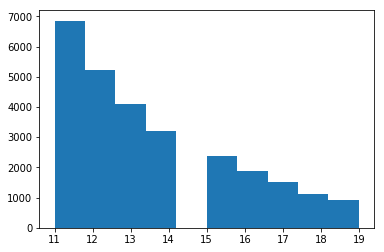

In [17]:
matplotlib.pyplot.hist(less_than_20)

(array([60458., 52737., 45966., 38159.,     0., 30886., 24588., 19216., 15085., 11627.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <a list of 10 Patch objects>)

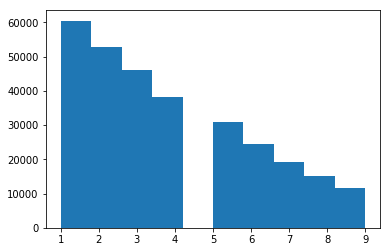

In [18]:
matplotlib.pyplot.hist(less_than_10)

(array([581., 462., 351., 320.,   0., 242., 198., 169., 134., 127.]),
 array([21. , 21.8, 22.6, 23.4, 24.2, 25. , 25.8, 26.6, 27.4, 28.2, 29. ]),
 <a list of 10 Patch objects>)

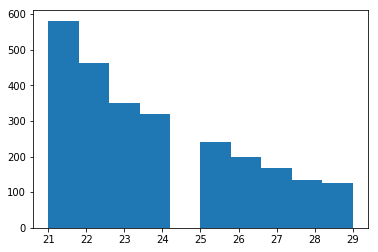

In [19]:
matplotlib.pyplot.hist(less_than_30)

(array([255.,  98.,  54.,  11.,  10.,   8.,  10.,   4.,   2.,   2.]),
 array([31. , 35.6, 40.2, 44.8, 49.4, 54. , 58.6, 63.2, 67.8, 72.4, 77. ]),
 <a list of 10 Patch objects>)

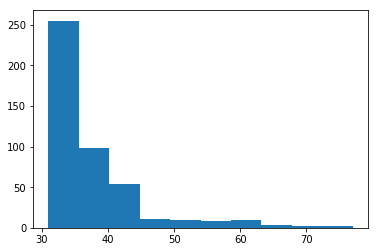

In [20]:
matplotlib.pyplot.hist(less_than_100)

In [21]:
def get_most_recent(prev_df):
    largest_idx = prev_df.groupby(["SK_ID_CURR"], sort=False)['DAYS_DECISION'].idxmax()
    return prev_df[prev_df.index.isin(largest_idx.values)]

In [22]:
nlargest_idx = prev.groupby(["SK_ID_CURR"], sort=False)['DAYS_DECISION'].idxmax()

In [23]:
prev_back = prev.copy()

In [24]:
dataframes = []
curr_prev = prev.copy()
for i in range(30):
    largest_idxs = curr_prev.groupby(["SK_ID_CURR"], sort=False)['DAYS_DECISION'].idxmax()
    largest_df = curr_prev.iloc[largest_idxs.values]
    curr_prev = curr_prev.drop(index=largest_idxs.values)
    dataframes.append(largest_df)
    curr_prev.reset_index(inplace=True)
    curr_prev.drop(columns=['index'],inplace=True)

In [25]:
length = 0
for df in dataframes:
    length += len(df)
assert(len(prev) - len(curr_prev) == length)

In [26]:
pickle.dump(dataframes, open(f'{PATH}/prev_dataframes.pkl','wb'))

In [27]:
dataframes = pickle.load(open(f'{PATH}/prev_dataframes.pkl', 'rb'))

In [28]:
suffix = "_ADD_" + str(1)

In [29]:
len(merged_df.columns)

214

In [30]:
join_df = merged_df.copy()
for i, df in enumerate(dataframes):
    suffix = "_ADD_" + str(i)
    join_df = pd.merge(join_df, df, how='left', on=['SK_ID_CURR'], suffixes=["", suffix])

In [31]:
join_df.to_pickle("data/join_df")

In [3]:
join_df = pickle.load(open('data/join_df','rb'))

In [10]:
join_df.shape

(356255, 1294)

In [11]:
# joined_df = pd.merge(merged_df, most_recent, how='left', on=['SK_ID_CURR'], suffixes=["", "_add_1"])

In [12]:
join_df[['DAYS_ID_PUBLISH', 'DAYS_BIRTH', 'DAYS_EMPLOYED']] = join_df.loc[:, ['DAYS_ID_PUBLISH', 'DAYS_BIRTH', 'DAYS_EMPLOYED']].replace([365243], value=0)

In [13]:
joined_df = join_df

In [19]:
train_df = joined_df.loc[joined_df[SK_ID_CURR].isin(application_train[SK_ID_CURR])]
test_df = joined_df.loc[joined_df[SK_ID_CURR].isin(application_test[SK_ID_CURR])]

In [20]:
assert(len(train_df) == len(application_train))

In [21]:
assert(len(test_df) == len(application_test))

In [22]:
len(train_df.columns)

1294

In [23]:
samp_size = len(train_df)

In [24]:
train_ratio  = 0.75
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(train_df)))

In [25]:
val_idx[:10]

[230633,
 230634,
 230635,
 230636,
 230637,
 230638,
 230639,
 230640,
 230641,
 230642]

In [26]:
column_type_map = joined_df.columns.to_series().groupby(joined_df.dtypes).groups

In [27]:
dtype_int64, dtype_float64, dtype_o = column_type_map.keys()

In [28]:
column_type_map[dtype_int64]

Index(['CNT_CHILDREN', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH',
       'FLAG_CONT_MOBILE', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
       'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
       'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_2',
       'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_EMAIL',
       'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'FLAG_PHONE', 'FLAG_WORK_PHONE',
       'HOUR_APPR_PROCESS_START', 'LIVE_CITY_NOT_WORK_CITY',
       'LIVE_REGION_NOT_WORK_REGION', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'SK_ID_CURR'],
      dtype='object')

In [29]:
column_type_map[dtype_o]

Index(['CODE_GENDER', 'EMERGENCYSTATE_MODE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'NAME_CONTRACT_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       ...
       'CODE_REJECT_REASON_ADD_29', 'NAME_TYPE_SUITE_ADD_29',
       'NAME_CLIENT_TYPE_ADD_29', 'NAME_GOODS_CATEGORY_ADD_29',
       'NAME_PORTFOLIO_ADD_29', 'NAME_PRODUCT_TYPE_ADD_29',
       'CHANNEL_TYPE_ADD_29', 'NAME_SELLER_INDUSTRY_ADD_29',
       'NAME_YIELD_GROUP_ADD_29', 'PRODUCT_COMBINATION_ADD_29'],
      dtype='object', length=515)

In [30]:
cat_vars  = list(set(column_type_map[dtype_int64])) + list(set(column_type_map[dtype_o]))

In [31]:
days = []
for var in cat_vars:
    if "DAYS" in var:
        days.append(var)

In [32]:
not_cat = ["SK_ID_CURR"] + days

In [33]:
not_cat

['SK_ID_CURR', 'DAYS_ID_PUBLISH', 'DAYS_EMPLOYED', 'DAYS_BIRTH']

In [34]:
cat_vars = list(set(cat_vars) - set(not_cat))

In [35]:
cat_vars = list(set(cat_vars) - set(days))

In [36]:
contin_vars = list(set(column_type_map[dtype_float64])) + not_cat

In [37]:
rm_list = ['SK_ID_PREV', 'SK_ID_PREV', 'SK_ID_PREV_ADD_1']

def rm(content, remove):
    return list(set(content) - set(remove))

contin_vars = rm(contin_vars, rm_list)
cat_vars = rm(cat_vars, rm_list)

In [38]:
not_cat

['SK_ID_CURR', 'DAYS_ID_PUBLISH', 'DAYS_EMPLOYED', 'DAYS_BIRTH']

In [39]:
contin_vars

['DAYS_DECISION_ADD_2',
 'DAYS_FIRST_DRAWING_ADD_21',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'RATE_DOWN_PAYMENT_ADD_2',
 'CNT_PAYMENT_ADD_16',
 'RATE_DOWN_PAYMENT_ADD_16',
 'YEARS_BEGINEXPLUATATION_AVG',
 'FLOORSMIN_MEDI',
 'HOUR_APPR_PROCESS_START_ADD_28',
 'RATE_INTEREST_PRIMARY_ADD_23',
 'COMMONAREA_MEDI',
 'FLOORSMAX_AVG',
 'CNT_DRAWINGS_ATM_CURRENT',
 'DAYS_LAST_DUE_1ST_VERSION_ADD_16',
 'DAYS_TERMINATION_ADD_2',
 'AMT_APPLICATION_ADD_6',
 'DAYS_FIRST_DRAWING_ADD_26',
 'DAYS_FIRST_DRAWING',
 'RATE_INTEREST_PRIMARY_ADD_21',
 'SK_ID_PREV_ADD_29',
 'SELLERPLACE_AREA_ADD_6',
 'AMT_DOWN_PAYMENT_ADD_13',
 'RATE_INTEREST_PRIVILEGED_ADD_22',
 'AMT_ANNUITY',
 'RATE_DOWN_PAYMENT_ADD_17',
 'RATE_INTEREST_PRIMARY_ADD_11',
 'DAYS_LAST_DUE_ADD_2',
 'LIVINGAPARTMENTS_MODE',
 'RATE_DOWN_PAYMENT_ADD_22',
 'AMT_DOWN_PAYMENT_ADD_12',
 'AMT_CREDIT_ADD_17',
 'RATE_DOWN_PAYMENT_ADD_3',
 'AMT_DOWN_PAYMENT_ADD_11',
 'HOUR_APPR_PROCESS_START_ADD_7',
 'DAYS_FIRST_DRAWING_ADD_15',
 'AMT_DRAWINGS_ATM_CURRENT',
 '

In [40]:
for v in cat_vars:
    train_df[v] = train_df[v].astype('category')
    test_df[v] = test_df[v].astype('category')

/home/cheeseblubber/anaconda3/envs/fastai-latest/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/cheeseblubber/anaconda3/envs/fastai-latest/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
for v in contin_vars:
    train_df[v] = train_df[v].fillna(0).astype('float32')
    test_df[v] = test_df[v].fillna(0).astype('float32')

/home/cheeseblubber/anaconda3/envs/fastai-latest/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/cheeseblubber/anaconda3/envs/fastai-latest/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
cat_sz = [(c, len(train_df[c].cat.categories)+1) for c in cat_vars]

In [ ]:
apply_cats(test_df, train_df)

In [ ]:
cat_sz

In [ ]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [ ]:
proc_train_df, y, _, mapper = proc_df(train_df, y_fld="TARGET", skip_flds=rm_list, do_scale=True)

In [ ]:
proc_test_df, _, nas, mapper = proc_df(test_df, do_scale=True, mapper=mapper)

In [ ]:
bs = 500

In [ ]:
y[:10]

In [ ]:
len(proc_test_df.columns)

In [ ]:
list(set(proc_test_df.columns) - set(proc_train_df.columns))

In [ ]:
proc_test_df.drop(columns=['SK_ID_PREV_na',
 'TARGET',
 'SK_ID_PREV_ADD_1',
 'SK_ID_PREV'], inplace=True)

In [89]:
proc_train_df.to_pickle("data/train_df_large")
proc_test_df.to_pickle("data/test_df_large")

In [4]:
proc_train_df = pickle.load(open("data/train_df_large",'rb'))
proc_test_df = pickle.load(open("data/test_df_large",'rb'))

In [6]:
test_df["TARGET"]

NameError: name 'test_df' is not defined

In [ ]:
"TARGET" in list(proc_train_df.columns)

In [90]:
list(set(proc_test_df.columns) - set(proc_train_df.columns))

[]

In [91]:
len(proc_test_df.columns)

1291

In [92]:
# proc_test_df.drop(columns=["SK_ID_PREV", "SK_ID_CURR"], inplace=True)

In [7]:
md = ColumnarModelData.from_data_frame(
    PATH, val_idx, proc_train_df, y.astype(np.int32), 
    cat_flds=cat_vars, bs=bs, is_reg=False, test_df=proc_test_df,
    is_multi=False
)

NameError: name 'val_idx' is not defined

In [317]:
m = md.get_learner(emb_szs, len(proc_train_df.columns)-len(cat_vars), 0.1, 2, [200,80], drops=[0.02, 0.02])

In [138]:
m.lr_find()

epoch      trn_loss   val_loss                               
    0      0.306683   0.278838  


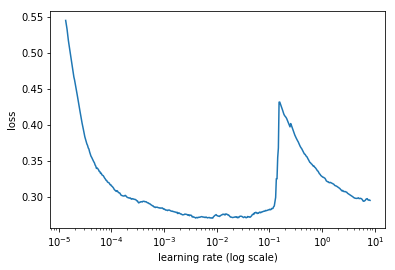

In [139]:
m.sched.plot()

In [126]:
lr = 1

In [140]:
m.fit(lr, 1, cycle_len=1)

epoch      trn_loss   val_loss                               
    0      0.253402   0.248738  


[array([0.24874])]

In [141]:
m.fit(lr, 1, cycle_len=1)

epoch      trn_loss   val_loss                               
    0      0.250012   0.246688  


[array([0.24669])]

In [142]:
m.fit(lr/100, 5, wds=1e-7, cycle_len=3, best_save_name="best_home_default1")

epoch      trn_loss   val_loss                               
    0      0.252344   0.246489  
    1      0.247104   0.246396                               
    2      0.248249   0.246369                               
    3      0.248922   0.246249                               
    4      0.253334   0.246308                               
    5      0.248723   0.246243                               
    6      0.250316   0.246179                               
    7      0.254383   0.246156                               
    8      0.240331   0.24614                                
    9      0.249766   0.246066                               
    10     0.246713   0.246037                               
    11     0.248492   0.246029                               
    12     0.247303   0.245967                               
    13     0.249159   0.245978                               
    14     0.245384   0.245953                               


[array([0.24595])]

In [130]:
m.load(name="best_home_default1")

In [143]:
m.fit(lr/100, 5, cycle_len=5, wds=1e-7, best_save_name="best_home_default2")

epoch      trn_loss   val_loss                               
    0      0.246404   0.245942  
    1      0.248413   0.245917                               
    2      0.245729   0.245856                               
    3      0.244269   0.245846                               
    4      0.247915   0.245843                               
    5      0.248115   0.245802                               
    6      0.240093   0.24577                                
    7      0.25027    0.245799                               
    8      0.248212   0.245726                               
    9      0.24428    0.245726                               
    10     0.247225   0.24569                                
    11     0.245732   0.245668                               
    12     0.247621   0.245682                               
    13     0.249186   0.245657                               
    14     0.249448   0.245651                               
    15     0.245074   0.24571        

[array([0.2455])]

In [ ]:
m.load(name="best_home_default2")

In [144]:
m.fit(lr/150, 5, cycle_len=5, wds=1e-7, best_save_name="best_home_default3")

epoch      trn_loss   val_loss                               
    0      0.243137   0.245518  
    1      0.246245   0.245518                               
    2      0.244545   0.245488                               
    3      0.247491   0.24549                                
    4      0.247086   0.24549                                
    5      0.247465   0.245505                               
    6      0.246197   0.245469                               
    7      0.246609   0.245461                               
    8      0.24499    0.245452                               
    9      0.248138   0.24545                                
    10     0.239641   0.245474                               
    11     0.244281   0.245445                               
    12     0.244971   0.245437                               
    13     0.243803   0.245444                               
    14     0.242034   0.245443                               
    15     0.244701   0.245431       

[array([0.2454])]

In [318]:
m.load(name="best_home_default3")

In [145]:
m.fit(lr/1000, 2, cycle_len=2, wds=1e-7, best_save_name="best_home_default3")

epoch      trn_loss   val_loss                               
    0      0.245299   0.245405  
    1      0.24449    0.245404                               
    2      0.242863   0.245402                               
    3      0.246765   0.245404                               


[array([0.2454])]

In [146]:
m.fit(lr/1000, 3, cycle_len=3, wds=1e-7, best_save_name="best_home_default3")

epoch      trn_loss   val_loss                               
    0      0.245964   0.245407  
    1      0.245996   0.245408                               
    2      0.247407   0.245407                               
    3      0.245071   0.245403                               
    4      0.242466   0.245405                               
    5      0.245242   0.245405                               
    6      0.241565   0.245404                               
    7      0.245236   0.245406                               
    8      0.244491   0.245407                               


[array([0.24541])]

In [136]:
m.summary

<bound method StructuredLearner.summary of MixedInputModel(
  (embs): ModuleList(
    (0): Embedding(9, 5)
    (1): Embedding(8, 4)
    (2): Embedding(6, 3)
    (3): Embedding(3, 2)
    (4): Embedding(18, 9)
    (5): Embedding(8, 4)
    (6): Embedding(9, 5)
    (7): Embedding(24, 12)
    (8): Embedding(8, 4)
    (9): Embedding(12, 6)
    (10): Embedding(3, 2)
    (11): Embedding(10, 5)
    (12): Embedding(12, 6)
    (13): Embedding(6, 3)
    (14): Embedding(8, 4)
    (15): Embedding(5, 3)
    (16): Embedding(17, 9)
    (17): Embedding(26, 13)
    (18): Embedding(5, 3)
    (19): Embedding(26, 13)
    (20): Embedding(6, 3)
    (21): Embedding(5, 3)
    (22): Embedding(3, 2)
    (23): Embedding(8, 4)
    (24): Embedding(26, 13)
    (25): Embedding(3, 2)
    (26): Embedding(4, 2)
    (27): Embedding(4, 2)
    (28): Embedding(22, 11)
    (29): Embedding(5, 3)
    (30): Embedding(3, 2)
    (31): Embedding(9, 5)
    (32): Embedding(5, 3)
    (33): Embedding(17, 9)
    (34): Embedding(3, 2)
  

In [157]:
class GradientMemory:
    def __init__(self):
        self.gradients = None
        
    def save_gradient(self, gradient):
        self.gradient = gradient
grad_memory = GradientMemory()

In [278]:
m.model.bs

1

In [284]:
inputs = next(m.data.val_dl.__iter__())

In [285]:
m.model.eval()

MixedInputModel(
  (embs): ModuleList(
    (0): Embedding(9, 5)
    (1): Embedding(8, 4)
    (2): Embedding(6, 3)
    (3): Embedding(3, 2)
    (4): Embedding(18, 9)
    (5): Embedding(8, 4)
    (6): Embedding(9, 5)
    (7): Embedding(24, 12)
    (8): Embedding(8, 4)
    (9): Embedding(12, 6)
    (10): Embedding(3, 2)
    (11): Embedding(10, 5)
    (12): Embedding(12, 6)
    (13): Embedding(6, 3)
    (14): Embedding(8, 4)
    (15): Embedding(5, 3)
    (16): Embedding(17, 9)
    (17): Embedding(26, 13)
    (18): Embedding(5, 3)
    (19): Embedding(26, 13)
    (20): Embedding(6, 3)
    (21): Embedding(5, 3)
    (22): Embedding(3, 2)
    (23): Embedding(8, 4)
    (24): Embedding(26, 13)
    (25): Embedding(3, 2)
    (26): Embedding(4, 2)
    (27): Embedding(4, 2)
    (28): Embedding(22, 11)
    (29): Embedding(5, 3)
    (30): Embedding(3, 2)
    (31): Embedding(9, 5)
    (32): Embedding(5, 3)
    (33): Embedding(17, 9)
    (34): Embedding(3, 2)
    (35): Embedding(10, 5)
    (36): Embeddin

In [183]:
inputs[0].shape

torch.Size([1000, 551])

In [184]:
inputs[1].shape

torch.Size([1000, 740])

In [185]:
inputs[2].shape

torch.Size([1000])

In [195]:
from matplotlib import pyplot as plt

def plot_kernels(tensor, num_cols=6):
    if not tensor.ndim==4:
        raise Exception("assumes a 4D tensor")
    if not tensor.shape[-1]==3:
        raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i])
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
    

In [200]:
mm = m.model.cpu().double()
filters = mm.modules
body_model = [i for i in mm.children()][0]
layer1 = body_model[0]
tensor = layer1.weight.data.numpy()
# plot_kernels(tensor)

In [207]:
map_index = {}
for i, part in enumerate(body_model):
    map_index[part] = part.weight.data.numpy().flatten().mean()
    map_index[i]

In [220]:
list(zip(cat_vars, cat_sz))

[('NAME_SELLER_INDUSTRY_ADD_14', ('NAME_SELLER_INDUSTRY_ADD_14', 9)),
 ('WEEKDAY_APPR_PROCESS_START_ADD_11',
  ('WEEKDAY_APPR_PROCESS_START_ADD_11', 8)),
 ('NAME_YIELD_GROUP_ADD_17', ('NAME_YIELD_GROUP_ADD_17', 6)),
 ('FLAG_LAST_APPL_PER_CONTRACT_ADD_19',
  ('FLAG_LAST_APPL_PER_CONTRACT_ADD_19', 3)),
 ('PRODUCT_COMBINATION_ADD_12', ('PRODUCT_COMBINATION_ADD_12', 18)),
 ('WEEKDAY_APPR_PROCESS_START_ADD_14',
  ('WEEKDAY_APPR_PROCESS_START_ADD_14', 8)),
 ('NAME_SELLER_INDUSTRY_ADD_15', ('NAME_SELLER_INDUSTRY_ADD_15', 9)),
 ('NAME_CASH_LOAN_PURPOSE_ADD_11', ('NAME_CASH_LOAN_PURPOSE_ADD_11', 24)),
 ('WEEKDAY_APPR_PROCESS_START_ADD_16',
  ('WEEKDAY_APPR_PROCESS_START_ADD_16', 8)),
 ('NAME_SELLER_INDUSTRY_ADD_6', ('NAME_SELLER_INDUSTRY_ADD_6', 12)),
 ('FLAG_EMAIL', ('FLAG_EMAIL', 3)),
 ('CODE_REJECT_REASON_ADD_19', ('CODE_REJECT_REASON_ADD_19', 10)),
 ('NAME_SELLER_INDUSTRY_ADD_1', ('NAME_SELLER_INDUSTRY_ADD_1', 12)),
 ('NAME_PORTFOLIO_ADD_4', ('NAME_PORTFOLIO_ADD_4', 6)),
 ('NAME_TYPE_SUITE'

In [224]:
mapped_all = list(zip(cat_sz, map_index.keys(), map_index.values()))

In [225]:
mapped_vars = list(zip(cat_vars, map_index.keys(), map_index.values()))

In [227]:
mapped_vars.sort(key=lambda val: val[2])

In [272]:
blah[-6], blah[-6][1].weight.data.numpy()

(('FLAG_OWN_REALTY', Embedding(3, 2), -0.1827018012603124),
 array([[-0.05233, -0.31353],
        [-0.54558, -0.62958],
        [ 0.54196, -0.09715]]))

In [265]:
blah[-3]

('LIVE_CITY_NOT_WORK_CITY', Embedding(3, 2), 0.20562358324726424)

In [267]:
blah[-3][1].weight.data.numpy()

array([[ 0.26422,  0.41892],
       [ 0.30409, -0.04571],
       [ 0.06304,  0.22918]])

In [259]:
blah[-1]

('FLAG_EMAIL', Embedding(3, 2), -0.23449238886435828)

In [262]:
blah[-1][1].weight.data.numpy()

array([[ 0.22638,  0.1342 ],
       [-0.60705, -0.1761 ],
       [-0.56889, -0.41549]])

In [249]:
blah = list(filter(lambda x: "ADD" not in x[0], mapped_vars))
blah.sort(key=lambda val: val[2] * val[2])
blah

[('STATUS', Embedding(9, 5), 5.030640297465854e-05),
 ('NAME_GOODS_CATEGORY', Embedding(27, 14), -9.479513318707831e-05),
 ('HOUR_APPR_PROCESS_START', Embedding(25, 13), 0.00011122352313787605),
 ('NAME_TYPE_SUITE_BAVG', Embedding(9, 5), 0.0006100246993203958),
 ('OCCUPATION_TYPE', Embedding(19, 10), 0.0009176009444912014),
 ('FLAG_MOBIL', Embedding(3, 2), 0.001126892864704132),
 ('CODE_REJECT_REASON', Embedding(10, 5), 0.002186075150966644),
 ('CHANNEL_TYPE', Embedding(9, 5), -0.00282101027874483),
 ('ORGANIZATION_TYPE', Embedding(59, 30), -0.0030212645908794795),
 ('WALLSMATERIAL_MODE', Embedding(8, 4), -0.005906391888856888),
 ('PRODUCT_COMBINATION', Embedding(19, 10), -0.006663800711057296),
 ('NAME_FAMILY_STATUS', Embedding(7, 4), 0.00731315603479743),
 ('NAME_CASH_LOAN_PURPOSE', Embedding(26, 13), 0.007652474671267125),
 ('WEEKDAY_APPR_PROCESS_START_BAVG', Embedding(8, 4), 0.011929990083444864),
 ('FLAG_EMP_PHONE', Embedding(3, 2), 0.015189647674560547),
 ('LIVE_REGION_NOT_WORK_R

In [206]:
body_model[0].

Embedding(9, 5)

In [ ]:
md = ColumnarModelData.from_data_frame(
    PATH, val_idx, proc_train_df, y.astype(np.int32), 
    cat_flds=cat_vars, bs=bs, is_reg=False, test_df=proc_test_df,
    is_multi=False
)
m = md.get_learner(emb_szs, len(proc_train_df.columns)-len(cat_vars), 0.1, 2, [200,80], drops=[0.02, 0.02])
m.load(name="best_home_default3")

In [ ]:
def predict_single_record(m, index):
    single_record = [np.array(i)[None] for i in m.data.test_ds[index]]
    return predict(m.model,[single_record])
predict_single_record(m,0)

In [332]:
mm = m.model.cpu().double()
filters = mm.modules
body_model = [i for i in mm.children()][0]
layer1 = body_model[0]
tensor = layer1.weight.data.numpy()
# plot_kernels(tensor)

In [335]:
body_model[1].weight

Parameter containing:
 0.3415  0.3382  0.0859 -0.0351
 0.1504 -0.1623  0.3722 -0.0401
-0.0902 -0.0078 -0.3715  0.3409
-0.3397  0.2466  0.3058  0.2531
-0.1004  0.0331  0.0485 -0.2729
 0.1288 -0.0073  0.2343 -0.1574
-0.0063 -0.2354  0.1201  0.2867
-0.0456  0.2043 -0.2490  0.3911
[torch.DoubleTensor of size 8x4]

In [160]:
pred_test=m.predict(True)

TypeError: save_gradient() takes 2 positional arguments but 4 were given

In [162]:
pred_test = np.exp(pred_test)

In [163]:
pred_test[:,0]

array([13.82907, 11.10759, 13.83319, 12.53119, 10.73574, 13.87259, 14.67338, 12.87069, 14.54613,  9.26813,
       13.76925, 13.35867, 10.82167, 13.4351 , 13.61886, 12.4327 , 12.95104, 14.35048, 11.84852, 13.14429,
       ..., 12.16585, 12.64424, 14.18048, 14.11379, 14.73338, 12.24751, 12.15067, 14.77848, 12.46649,
       14.0933 , 13.12383, 13.23462, 14.29435, 11.83216, 13.62054, 13.85384, 11.75379, 14.11008, 12.51387,
       10.35898], dtype=float32)

(array([   18.,   240.,   819.,  1423.,  2165.,  3355.,  5286.,  8564., 14423., 12451.]),
 array([ 4.18325,  5.28035,  6.37745,  7.47456,  8.57166,  9.66876, 10.76586, 11.86296, 12.96006, 14.05716,
        15.15426]),
 <a list of 10 Patch objects>)

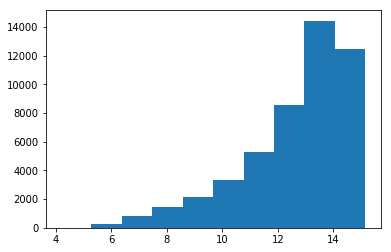

In [164]:
matplotlib.pyplot.hist(pred_test[:,0])

In [165]:
application_test['TARGET']=pred_test[:,1]

In [166]:
csv_fn=f'{PATH}/tmp/sub10.csv'

In [153]:
application_test['SK_ID_CURR'] = application_test['SK_ID_CURR'].astype(int)

In [154]:
application_test[['SK_ID_CURR','TARGET']].to_csv(csv_fn, index=False)

In [155]:
FileLink(csv_fn)

/home/cheeseblubber/workspace/competition/home-default-credit/data/tmp/sub10.csv